# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

## Data Import

In [270]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [271]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [272]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 35


In [273]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [274]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_6-8',
       'Traffic_9-11', 'Traffic_12-14', 'Traffic_15-17', 'Traffic_18-20',
       'Traffic_21-0', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT',
       'W_VEC_DIR', 'LEAFW', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_rbf_1',
       'month_rbf_2', 'month_rbf_3', 'month_rbf_4', 'month_rbf_5',
       'month_rbf_6', 'month_rbf_7', 'month_rbf_8', 'month_rbf_9',
       'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

In [275]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'
RANDOM_STATE = 42

In [276]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [277]:
training_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.052885,0.096698,0.0,0.911899,0.0,0.034247,0.579722,0.0,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


## **Hourly agents**

As a test, let's see if the same agent-model achieves similar performances on all the stations.

In [312]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, sequences:bool)

#### **Random Forest Regressor**

##### Models:

In [313]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [314]:
rfr2_params = {
    'n_estimators':500,
    'max_depth':15,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

hour_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

##### *Testing...*

In [281]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

rfr_model = RandomForestRegressor(**rfr_params)
rfr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


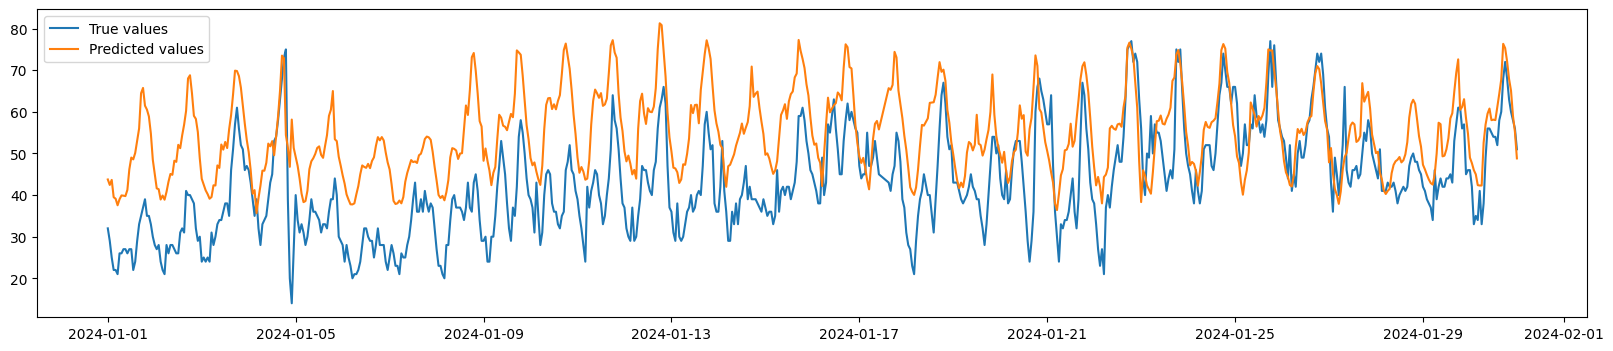

root_mean_squared_error: 19.537648933894275
r2_score: -0.8985217845365889
mean_absolute_error: 16.68827371169942
huber: 3.317685604095459


In [282]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

rfr_scores={}
for m in metrics:
    rfr_score = m(test_sets[station][agent]['y'],rfr_pred_df)
    print(f'{m.__name__}: {rfr_score}')
    rfr_scores[m.__name__] = rfr_score

#### **XGBoost**

##### Models:

In [315]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [316]:
xgbr2_params = {
    'objective': "reg:squarederror",
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.75,
    'random_state': RANDOM_STATE
}

hour_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr2_params, None, False)

##### *Testing...*

In [285]:
agent = 'PORTA SAN FELICE'
agent = 'O3'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

KeyError: 'O3'

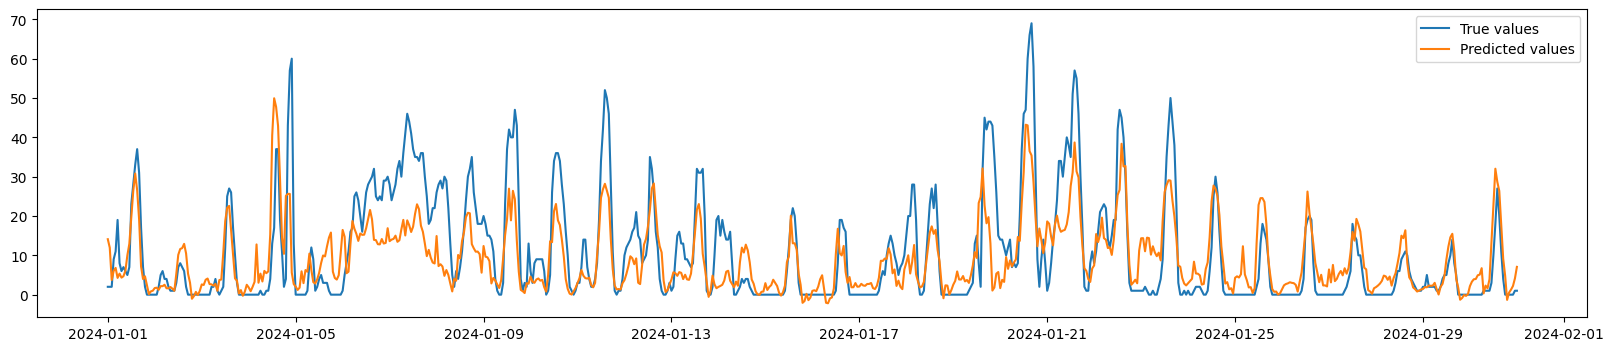

root_mean_squared_error: 13.877034469701544
r2_score: 0.8504408475828759
mean_absolute_error: 10.44955231401659
huber: 2.0700161457061768


In [ ]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

#### **LSTM**

##### Models

In [317]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': False # fill nan using bfill()
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (build_lstm_model, lstm_params, lstm_train_params, True)

In [318]:
masked_lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True # apply a mask to nan, instead of filling
}

masked_lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM-masked'] = (build_lstm_model, masked_lstm_params, masked_lstm_train_params, True)

In [319]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': False
}

lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2'] = (build_lstm_model, lstm2_params, lstm2_train_params, True)


In [320]:
masked_lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

masked_lstm2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM 2-masked'] = (build_lstm_model, masked_lstm2_params, masked_lstm2_train_params, True)


##### *Testing...*

In [ ]:
station = 'GIARDINI MARGHERITA'
agent = 'NO2'

ts = lstm_params['time_steps']
lstm_x_train, lstm_y_train = create_sequences(training_sets[station][agent]['x'], training_sets[station][agent]['y'], ts, use_mask=False)

lstm_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_x_test, lstm_y_test = create_sequences(lstm_x_test, test_sets[station][agent]['y'], ts, use_mask=False)

In [ ]:
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = build_lstm_model(**lstm_params)
lstm_model.fit(
    lstm_x_train,
    lstm_y_train,
    **lstm_train_params
)
lstm_pred = lstm_model.predict(lstm_x_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)

Epoch 1/20
668/668 [==============================] - 5s 3ms/step - loss: 6.4959
Epoch 2/20
668/668 [==============================] - 2s 3ms/step - loss: 5.3761
Epoch 3/20
668/668 [==============================] - 2s 3ms/step - loss: 5.2511
Epoch 4/20
668/668 [==============================] - 2s 3ms/step - loss: 5.1915
Epoch 5/20
668/668 [==============================] - 2s 3ms/step - loss: 5.1348
Epoch 6/20
668/668 [==============================] - 2s 3ms/step - loss: 5.0900
Epoch 7/20
668/668 [==============================] - 2s 3ms/step - loss: 5.0431
Epoch 8/20
668/668 [==============================] - 2s 3ms/step - loss: 4.9814
Epoch 9/20
668/668 [==============================] - 2s 3ms/step - loss: 4.9419
Epoch 10/20
668/668 [==============================] - 2s 3ms/step - loss: 4.8499
Epoch 11/20
668/668 [==============================] - 2s 3ms/step - loss: 4.7666
Epoch 12/20
668/668 [==============================] - 2s 3ms/step - loss: 4.6839
Epoch 13/20
668/668 [====

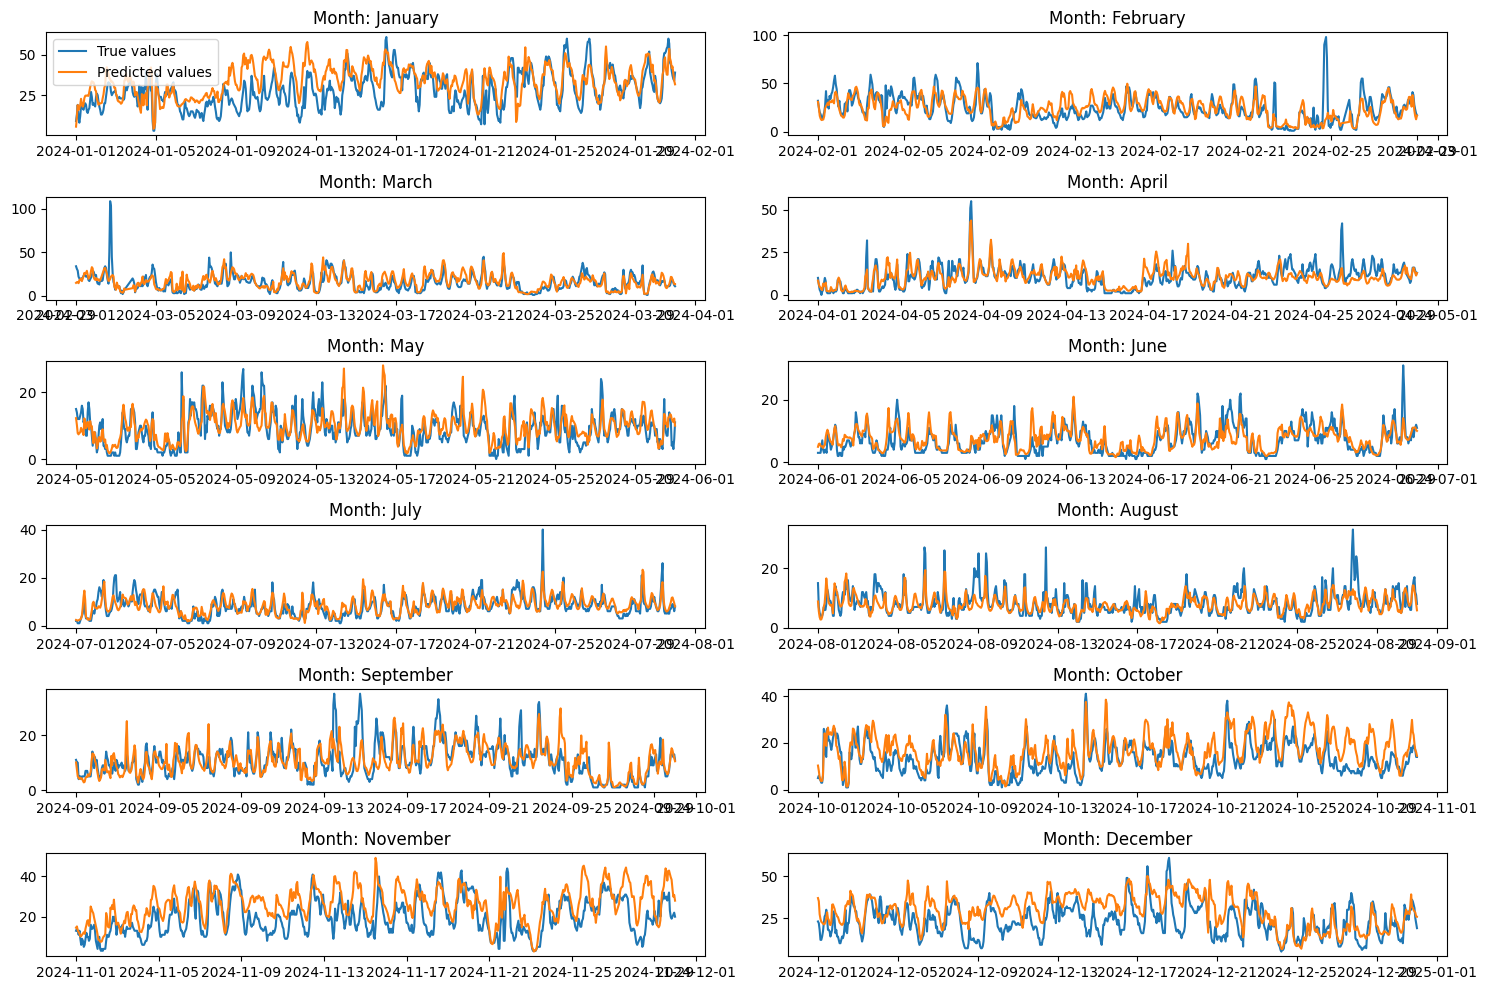

root_mean_squared_error: 7.02989112822942 (7.953116534847338)
r2_score: 0.5576846287723488 (0.5847334097263513)
mean_absolute_error: 4.740561764520725 (5.279064677960013)
huber: 0.9284008145332336 (1.0360610485076904)


In [ ]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 29 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(lstm_y_test[(lstm_y_test.index >= start) & (lstm_y_test.index <= end)], label='True values')
    plt.plot(lstm_pred_df[(lstm_pred_df.index >= start) & (lstm_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()
    
plt.tight_layout()
plt.show()

lstm_scores={}
for m in metrics:
    lstm_score = m(lstm_y_test,lstm_pred_df)
    lstm_score_half = m(lstm_y_test[(lstm_y_test.index>=datetime(2024,1,1))&(lstm_y_test.index<=datetime(2024,5,31))],lstm_pred_df[(lstm_pred_df.index>=datetime(2024,1,1))&(lstm_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {lstm_score} ({lstm_score_half})')
    lstm_scores[m.__name__] = lstm_score

#### **Feed Forward Neural Network**

##### Models

In [321]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [322]:
bn_ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_params, bn_ffnn_train_params, False)

In [323]:
ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2'] = (build_ffnn_model, ffnn2_params, ffnn2_train_params, False)

In [324]:
bn_ffnn2_params = {
    'input_size': n_hour_features,
    'neurons': [512, 256, 128],
    'batch_norm': True,
    'dropout': 0.3,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

bn_ffnn2_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN 2 BatchNorm'] = (build_ffnn_model, bn_ffnn2_params, bn_ffnn2_train_params, False)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
1343/1343 [==============================] - 11s 8ms/step - loss: 12.5852
Epoch 2/10
1343/1343 [==============================] - 10s 8ms/step - loss: 11.4125
Epoch 3/10
1343/1343 [==============================] - 10s 8ms/step - loss: 11.0066
Epoch 4/10
1343/1343 [==============================] - 10s 8ms/step - loss: 10.8743
Epoch 5/10
1343/1343 [==============================] - 10s 8ms/step - loss: 10.7736
Epoch 6/10
1343/1343 [==============================] - 10s 8ms/step - loss: 10.6685
Epoch 7/10
1343/1343 [==============================] - 10s 8ms/step - loss: 10.5714
Epoch 8/10
1343/1343 [==============================] - 10s 8ms/step - loss: 10.5357
Epoch 9/10
1343/1343 [==============================] - 10s 8ms/step - loss: 10.4942
Epoch 10/10
269/269 [==============================] - 1s 3ms/step


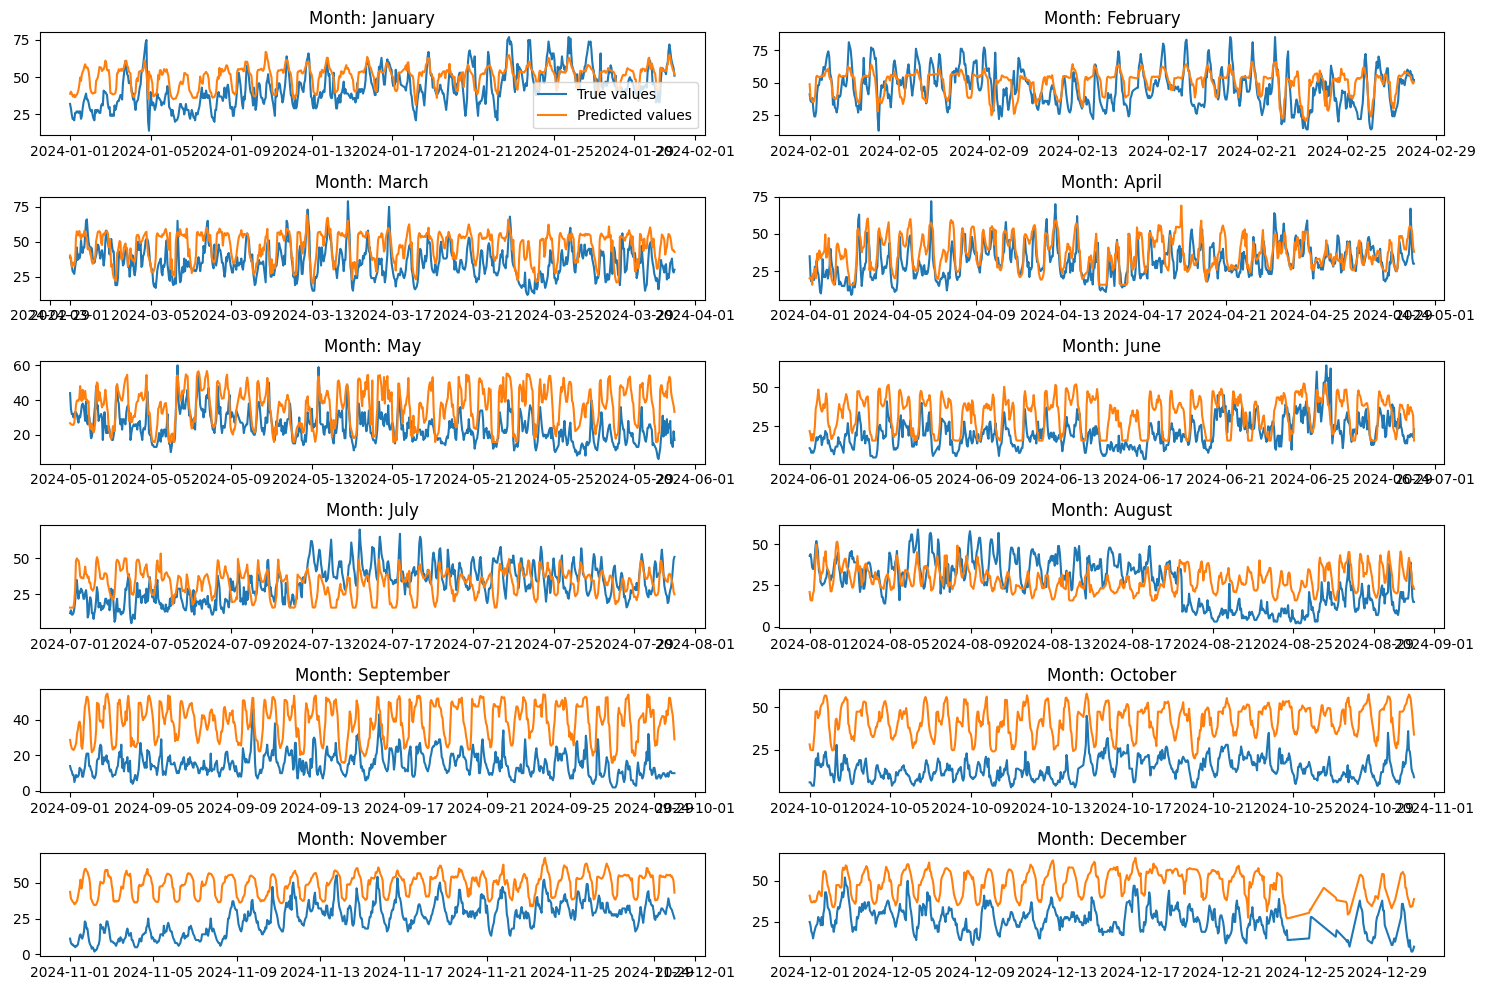

root_mean_squared_error: 18.606221277141717 (13.325647776455906)
r2_score: -0.7218184004877704 (0.05961267850658514)
mean_absolute_error: 15.770770654177696 (10.924377205767676)
huber: 3.1341965198516846 (2.1649439334869385)


In [ ]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(ffnn_pred_df[(ffnn_pred_df.index >= start) & (ffnn_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,ffnn_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],ffnn_pred_df[(ffnn_pred_df.index>=datetime(2024,1,1))&(ffnn_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

#### **Conv1d**

##### Models

In [325]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

In [326]:
conv2_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv2_train_params = {
    'epochs': 10,
    'batch_size': 64,
}

hour_models['Conv1D 2'] = (build_conv_model, conv2_params, conv2_train_params, True)

In [327]:
conv3_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': [64, 32],
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv3_train_params = {
    'epochs': 20,
    'batch_size': 32,
}

hour_models['Conv1D 3'] = (build_conv_model, conv3_params, conv3_train_params, True)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ts = conv_params['time_steps']
conv_x_train, conv_y_train = create_sequences(training_sets[station][agent]['x'], training_sets[station][agent]['y'], ts, use_mask=False)

conv_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts+1:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
conv_x_test, conv_y_test = create_sequences(conv_x_test, test_sets[station][agent]['y'], ts, use_mask=False)


Epoch 1/10
671/671 [==============================] - 2s 2ms/step - loss: 12.1900
Epoch 2/10
671/671 [==============================] - 2s 2ms/step - loss: 9.9458
Epoch 3/10
671/671 [==============================] - 2s 2ms/step - loss: 9.7394
Epoch 4/10
671/671 [==============================] - 2s 2ms/step - loss: 9.5621
Epoch 5/10
671/671 [==============================] - 2s 3ms/step - loss: 9.4470
Epoch 6/10
671/671 [==============================] - 2s 3ms/step - loss: 9.4047
Epoch 7/10
671/671 [==============================] - 2s 3ms/step - loss: 9.2927
Epoch 8/10
671/671 [==============================] - 2s 3ms/step - loss: 9.2042
Epoch 9/10
671/671 [==============================] - 2s 3ms/step - loss: 9.1504
Epoch 10/10
269/269 [==============================] - 0s 877us/step


In [ ]:
tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**conv_params)
conv_model.fit(conv_x_train, conv_y_train, **conv_train_params)
conv_pred = conv_model.predict(conv_x_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

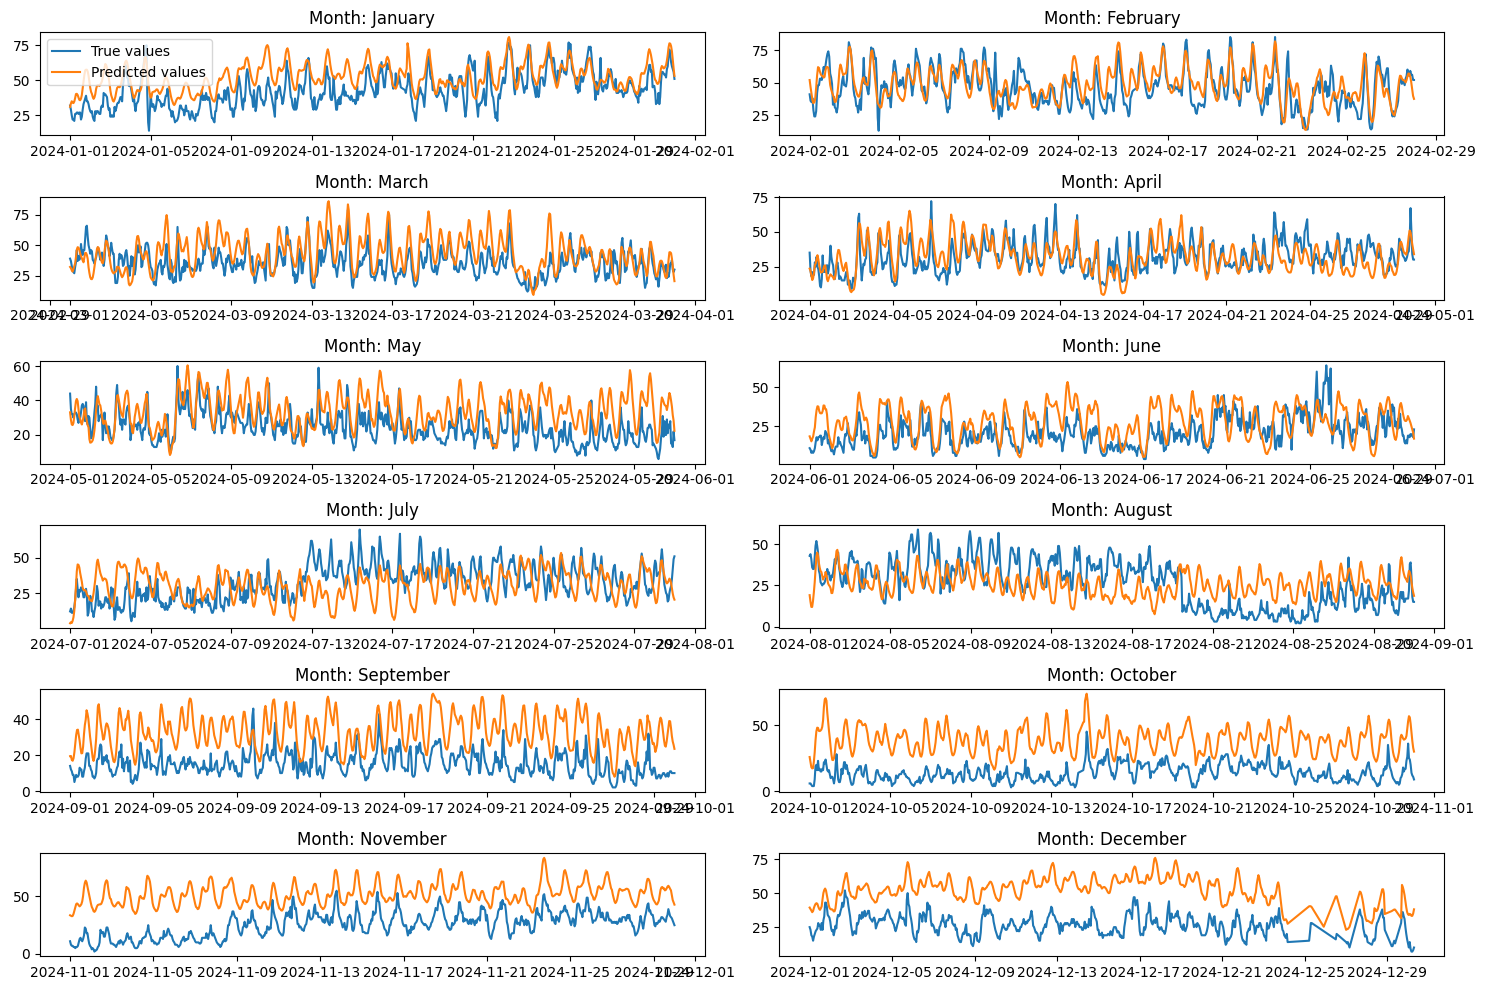

root_mean_squared_error: 17.643216507113358 (11.783037480289694)
r2_score: -0.5481980234294392 (0.26473376304646146)
mean_absolute_error: 14.64515127756587 (9.632316114504029)
huber: 2.9090752601623535 (1.9065334796905518)


In [ ]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(conv_pred_df[(conv_pred_df.index >= start) & (conv_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,conv_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],conv_pred_df[(conv_pred_df.index>=datetime(2024,1,1))&(conv_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

## **Daily agents**

In [303]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, sequences:bool|dict)

#### **Random Forest Regressor**

##### Models

In [304]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

In [305]:
rfr2_params = {
    'n_estimators':150,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE
}

daily_models['Random Forest Regressor 2'] = (RandomForestRegressor, rfr2_params, None, False)

#### **XGBoost Regressor**

##### Models

In [306]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

In [307]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 150,
    'max_depth': 10,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

daily_models['XGB Regressor 2'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing...*

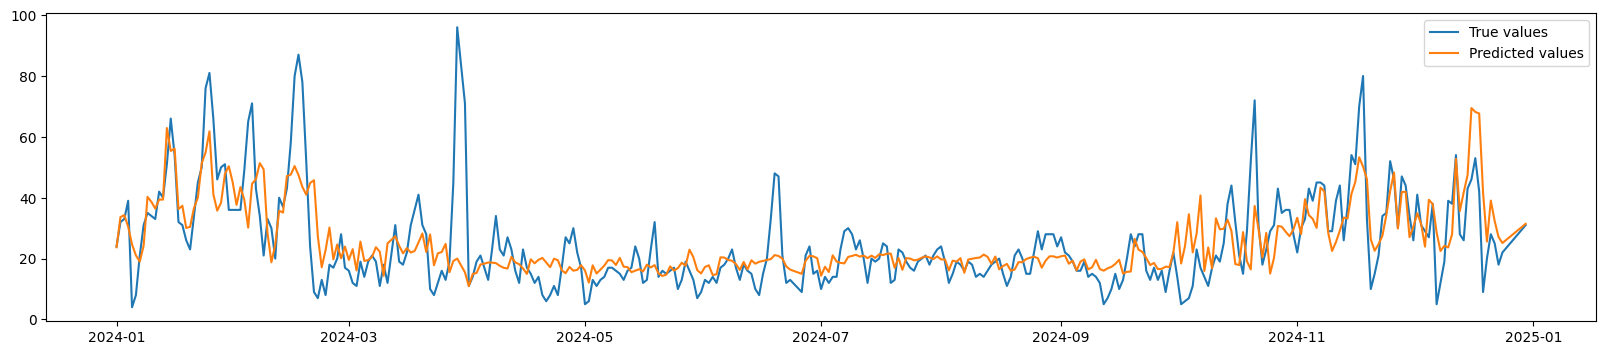

root_mean_squared_error: 11.319150673587734
r2_score: 0.4592027983565873
mean_absolute_error: 7.5843483598044745
huber: 1.4970206022262573


In [ ]:
station = 'PORTA SAN FELICE'
agent = 'PM10'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)
start = datetime(2024,1,1)
end = datetime(2024,12,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

#### **FFNN**

##### Models

In [308]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [309]:
bn_ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'batch_norm': True,
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

bn_ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32,
}

daily_models['Feed Forward NN BatchNorm'] = (build_ffnn_model, bn_ffnn_daily_params, bn_ffnn_daily_train_params, False)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'PM10'

tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/20
56/56 [==============================] - 1s 8ms/step - loss: 10.5166
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 7.8112
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 7.4324
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 7.2739
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 7.1448
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 7.0733
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 7.1189
Epoch 8/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7976
Epoch 9/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7300
Epoch 10/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7892
Epoch 11/20
56/56 [==============================] - 0s 6ms/step - loss: 6.7961
Epoch 12/20
56/56 [==============================] - 0s 6ms/step - loss: 6.5419
Epoch 13/20
56/56 [=============================

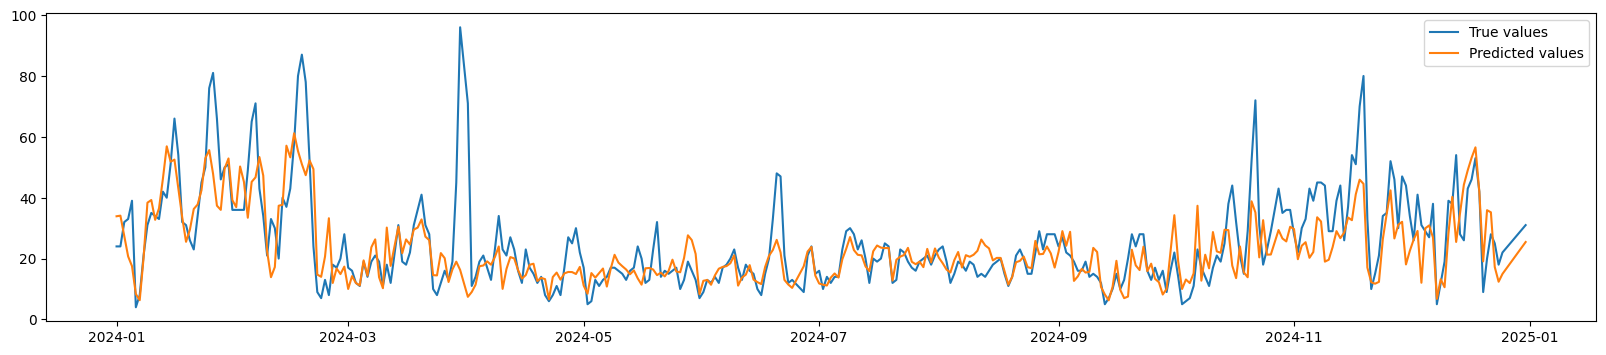

root_mean_squared_error: 10.9906479761611
r2_score: 0.48993823260576597
mean_absolute_error: 6.997144942872979
huber: 1.3796519041061401


In [ ]:
start = datetime(2024,1,1)
end = datetime(2024,12,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

ffnn_scores={}
for m in metrics:
    ffnn_score = m(test_sets[station][agent]['y'],ffnn_pred_df)
    print(f'{m.__name__}: {ffnn_score}')
    ffnn_scores[m.__name__] = ffnn_score

#### **LSTM**

In order to use LSTM, we should have sequences/time steps. For the other models, be aggregated the hourly data into a single day, but we could try to use 24 hours to predict the daily value.

The tests results were not convincing enough to keep experimentating.

## **Agents Evaluations**

### Hour Models

In [329]:
hour_results = train_models(
    hour_models,training_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['C6H6', 'O3', 'CO', 'NO2']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'LSTM', 'LSTM-masked', 'LSTM 2', 'LSTM 2-masked', 'Feed Forward NN', 'Feed Forward NN BatchNorm', 'Feed Forward NN 2', 'Feed Forward NN 2 BatchNorm', 'Conv1D', 'Conv1D 2', 'Conv1D 3']
Agent C6H6
> Random Forest Regressor model:
 >> Training station PORTA SAN FELICE...
> Random Forest Regressor 2 model:
 >> Training station PORTA SAN FELICE...
> XGB Regressor model:
 >> Training station PORTA SAN FELICE...
> XGB Regressor 2 model:
 >> Training station PORTA SAN FELICE...
> LSTM model:
 >> Training station PORTA SAN FELICE...
> LSTM-masked model:
 >> Training station PORTA SAN FELICE...
> LSTM 2 model:
 >> Training station PORTA SAN FELICE...
> LSTM 2-masked model:
 >> Training station PORTA SAN FELICE...
> Feed Forward NN model:
 >> Training station PORTA SAN FELICE..

KeyboardInterrupt: 

In [ ]:
hour_extracted_data = extract_data(hour_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,LSTM-masked,6.784603,0.588013,4.586678,0.897590
10,GIARDINI MARGHERITA,O3,LSTM_2,12.603757,0.875465,9.488341,1.877781
23,PORTA SAN FELICE,C6H6,LSTM_2-masked,0.412054,0.657019,0.264692,0.037230
12,PORTA SAN FELICE,NO2,LSTM-masked,18.497270,-0.701713,15.480646,3.076169
25,VIA CHIARINI,NO2,LSTM,6.775676,0.581930,5.152271,1.010630
30,VIA CHIARINI,O3,LSTM-masked,12.939649,0.869964,9.694309,1.918977


,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,LSTM-masked,6.784603,0.588013,4.586678,0.897590
2,GIARDINI MARGHERITA,NO2,LSTM-old,6.795247,0.586719,4.633741,0.907024
5,GIARDINI MARGHERITA,NO2,LSTM_2-masked,7.067549,0.552933,4.895375,0.959317
1,GIARDINI MARGHERITA,NO2,LSTM,7.115367,0.546863,4.860455,0.952378
3,GIARDINI MARGHERITA,NO2,LSTM-old-masked,7.192003,0.537049,4.910577,0.962360
4,GIARDINI MARGHERITA,NO2,LSTM_2,7.346109,0.516997,5.083519,0.996934
10,GIARDINI MARGHERITA,O3,LSTM_2,12.603757,0.875465,9.488341,1.877781
11,GIARDINI MARGHERITA,O3,LSTM_2-masked,12.828364,0.870987,9.632454,1.906620
7,GIARDINI MARGHERITA,O3,LSTM,13.174434,0.863933,9.823795,1.944943
6,GIARDINI MARGHERITA,O3,LSTM-masked,13.394470,0.859350,9.971862,1.974545


###### old complete results... do  not override

In [30]:
hour_extracted_data = extract_data(hour_results)
# hour_extracted_data.sort_values(by=[])
hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()]

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
17,GIARDINI MARGHERITA,NO2,LSTM,6.725825,0.595120,4.597018,0.899681
1,GIARDINI MARGHERITA,O3,LSTM-old,12.410668,0.879252,9.256034,1.831409
67,PORTA SAN FELICE,C6H6,Conv1D-5,0.404434,0.669587,0.258625,0.035957
34,PORTA SAN FELICE,CO,Conv1D-2,0.208691,0.567442,0.159813,0.017457
52,PORTA SAN FELICE,NO2,Conv1D-5,16.374771,-0.333587,13.510690,2.682191
102,VIA CHIARINI,NO2,Conv_res1D-3,6.400351,0.626964,4.881195,0.956431
88,VIA CHIARINI,O3,LSTM_2,12.797524,0.872805,9.610663,1.902263


In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
17,GIARDINI MARGHERITA,NO2,LSTM,6.725825,0.595120,4.597018,0.899681
27,GIARDINI MARGHERITA,NO2,Conv_res1D-3,6.737407,0.593725,4.590713,0.898538
19,GIARDINI MARGHERITA,NO2,Conv1D-2,6.959523,0.566495,4.842446,0.948732
18,GIARDINI MARGHERITA,NO2,Conv1D,7.090805,0.549986,4.926297,0.965509
28,GIARDINI MARGHERITA,NO2,LSTM_2,7.134573,0.544414,5.023153,0.984847
23,GIARDINI MARGHERITA,NO2,Conv_res1D,7.229194,0.532249,4.931438,0.966590
26,GIARDINI MARGHERITA,NO2,Conv_res1D-2,7.244927,0.530211,5.033745,0.986976
24,GIARDINI MARGHERITA,NO2,Conv_res1D-1,7.297735,0.523337,5.136712,1.007573
21,GIARDINI MARGHERITA,NO2,Conv1D-4,7.426482,0.506371,5.234638,1.027122
15,GIARDINI MARGHERITA,NO2,Random Forest Regressor,7.435556,0.505163,5.517238,1.083616


##### **EXAMPLE:** how to eventually try new metrics

In [ ]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates. Anyways, be careful :)

In [ ]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = extract_data(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
1,GIARDINI MARGHERITA,NO2,XGB Regressor,7.693566,0.470227,5.591722,59.190959
3,VIA CHIARINI,NO2,XGB Regressor,8.510072,0.340508,6.351527,72.421325
0,GIARDINI MARGHERITA,O3,XGB Regressor,14.529542,0.834502,10.980940,211.107599
2,VIA CHIARINI,O3,XGB Regressor,14.504967,0.836600,10.876629,210.394056


### Daily Models

In [310]:
daily_results = train_models(
    daily_models, training_sets, test_sets, metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'Random Forest Regressor 2', 'XGB Regressor', 'XGB Regressor 2', 'Feed Forward NN', 'Feed Forward NN BatchNorm']
Agent PM10
> Random Forest Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Random Forest Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> XGB Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> XGB Regressor 2 model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training s

In [311]:
daily_extracted_data = extract_data(daily_results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.loc[daily_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()])
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,10.331645,0.425994,7.285284,1.437294
10,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,8.115255,0.513886,5.741220,1.128417
16,PORTA SAN FELICE,PM10,Feed Forward NN,10.706182,0.516000,7.553299,1.490715
22,PORTA SAN FELICE,PM2.5,Feed Forward NN,7.312949,0.629611,5.018743,0.983883
28,VIA CHIARINI,PM10,Feed Forward NN,11.093667,0.353007,8.191600,1.618393


,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,10.331645,0.425994,7.285284,1.437294
4,GIARDINI MARGHERITA,PM10,Feed Forward NN,10.451412,0.412609,7.236141,1.427368
1,GIARDINI MARGHERITA,PM10,Random Forest Regressor 2,10.505820,0.406477,7.406928,1.461484
3,GIARDINI MARGHERITA,PM10,XGB Regressor 2,10.825559,0.369800,7.773056,1.534819
5,GIARDINI MARGHERITA,PM10,Feed Forward NN BatchNorm,11.009735,0.348175,7.710973,1.522349
2,GIARDINI MARGHERITA,PM10,XGB Regressor,11.013886,0.347683,7.918155,1.563823
10,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,8.115255,0.513886,5.741220,1.128417
11,GIARDINI MARGHERITA,PM2.5,Feed Forward NN BatchNorm,8.148746,0.509866,5.495568,1.079376
7,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor 2,8.491924,0.467713,5.943216,1.168725
6,GIARDINI MARGHERITA,PM2.5,Random Forest Regressor,8.498818,0.466849,5.910580,1.162195


###### old

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(daily_extracted_data.sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
1,GIARDINI MARGHERITA,PM10,Feed Forward NN-BN,10.472045,0.410287,7.047342,1.389783
0,GIARDINI MARGHERITA,PM10,Feed Forward NN,10.483455,0.409002,7.139633,1.408101
3,GIARDINI MARGHERITA,PM10,Feed Forward NN-huber-BN,10.888393,0.362463,7.377830,1.455682
2,GIARDINI MARGHERITA,PM10,Feed Forward NN-huber,13.174327,0.066672,8.760230,1.732170
4,GIARDINI MARGHERITA,PM2.5,Feed Forward NN,8.359619,0.484170,5.825541,1.145298
7,GIARDINI MARGHERITA,PM2.5,Feed Forward NN-huber-BN,8.629876,0.450279,5.886092,1.157427
5,GIARDINI MARGHERITA,PM2.5,Feed Forward NN-BN,8.710498,0.439960,5.942026,1.168576
6,GIARDINI MARGHERITA,PM2.5,Feed Forward NN-huber,12.239907,-0.105833,7.780451,1.536090
9,PORTA SAN FELICE,PM10,Feed Forward NN-BN,10.845932,0.503282,7.029507,1.386100
11,PORTA SAN FELICE,PM10,Feed Forward NN-huber-BN,10.856491,0.502314,7.176424,1.415543
